# **IMPORT**

In [1]:
import os
import ast
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from torch.utils.data import DataLoader, Subset, random_split
from tqdm import tqdm
from typing import Dict
from sklearn.metrics import f1_score, accuracy_score

# **FUNCTIONS**

In [2]:
def save_json(path, content):
    with open(path, "w", encoding="utf-8") as file:
        json.dump(content, file, ensure_ascii=False, indent=3)


def load_json(path):
    with open(path, "r", encoding="utf-8") as file:
        json_file = json.load(file)
        return json_file


# **LOAD DATA**

## ***Load CIFAR10***

In [3]:
BATCH_SIZE = 128

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)


## ***Train - Dev - Test***

In [5]:
train_size = int(0.8 * len(train_dataset))
dev_size = len(train_dataset) - train_size

In [6]:
train_dataset, dev_dataset= random_split(train_dataset, [train_size, dev_size])

train_fullset_size = int(train_size * 0.5)
others_fullset_size = int(len(train_dataset) - train_fullset_size)
train_dataset_fullset, _= random_split(train_dataset, [train_fullset_size, others_fullset_size])


In [7]:
train_loader_fullset = DataLoader(train_dataset_fullset, batch_size=len(train_dataset_fullset), shuffle=False, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dev_loader = DataLoader(dev_dataset, batch_size=100, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# **BUILD MODEL**

## ***Build Model***

In [8]:
class SimpleCNN(nn.Module):
    """
    Một mô hình CNN cơ bản cho bài toán Image Classification.
    Cấu trúc:
      - 3 khối convolution + batchnorm + relu + maxpool
      - 2 tầng fully-connected để phân loại
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Block 1: Conv -> BN -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),  # CIFAR-10 có input 32x32 → sau 3 lần pool còn 4x4
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

## ***Optimizer***

In [9]:
EPOCHS = 30
LR = 1e-4

In [10]:
optimizers_list = {
    "GD": (optim.SGD, {"lr": LR}), # Gradient Descent
    "SGD": (optim.SGD, {"lr": LR}), # Schocastic Gradient Descent
    "AdaGrad": (optim.Adagrad, {"lr": LR}), # AdaGrad
    "Adam": (optim.Adam, {"lr": LR}) # Adam
}

# **TRAINING**

## ***Trainer Class***

In [11]:
class Trainer:
    def __init__(self, optimizer_name, optimizer_cls, optimizer_params, epochs, save_dir) -> None:
        self.epochs = epochs
        self.save_dir = save_dir
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.optimizer_name = optimizer_name
        self.optimizer_cls = optimizer_cls
        self.optimizer_params = optimizer_params

        self.load()

    #-- Load
    def load(self):
        self.load_model()
        self.load_optimizer()
        self.load_loss_fn()
        self.load_ckpt()

    def load_model(self):
        self.model = SimpleCNN()
        self.model = self.model.to(self.device)

    def load_optimizer(self):
        self.optimizer = self.optimizer_cls(self.model.parameters(), **self.optimizer_params)

    def load_loss_fn(self):
        self.criterion = nn.CrossEntropyLoss()

    #-- Training
    def train(
            self,
            train_loader,
            val_loader
        ):
        train_losses = []
        val_losses = []
        epoch_val_logs = {}

        best_f1 = -1000

        pbar = tqdm(range(self.epochs), desc="Training Process ...")
        for epoch in pbar:
            #~ Training
            self.model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                loss_scalar = loss.detach().cpu().item()
                train_losses.append(loss_scalar)

            #~ Validation
            self.model.eval()
            all_predicts = []
            all_targets = []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    _, predicts = torch.max(outputs, 1)

                    #~ Save inferences
                    all_predicts.extend(predicts.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

                    #~ Calculate Loss
                    loss = self.criterion(outputs, targets)
                    loss_scalar = loss.detach().cpu().item()
                    val_losses.append(loss_scalar)

            val_acc = accuracy_score(all_targets, all_predicts)
            val_f1_macro = f1_score(all_targets, all_predicts, average='macro')
            val_f1_weighted = f1_score(all_targets, all_predicts, average='weighted')

            if val_f1_macro > best_f1:
                self.save_checkpoint()

            #~ Save Log
            train_loss_avg = sum(train_losses) / len(train_losses),
            val_loss_avg = sum(val_losses) / len(val_losses)

            epoch_log = {
                "train_loss": f"{train_loss_avg}",
                "val_loss": f"{val_loss_avg}",
                "val_acc": val_acc,
                "val_f1_macro": val_f1_macro,
                "val_f1_weighted": val_f1_weighted
            }
            pbar.set_postfix(epoch_log)
            epoch_val_logs[epoch] = epoch_log

        return epoch_val_logs


    def inference(self, test_loader):
        all_predicts = []
        all_targets = []
        test_losses = []
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc="Inferencing"):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                _, predicts = torch.max(outputs, 1)

                #~ Save inferences
                all_predicts.extend(predicts.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

                #~ Calculate Loss
                loss = self.criterion(outputs, targets)
                loss_scalar = loss.detach().cpu().item()
                test_losses.append(loss_scalar)

            test_loss_avg = sum(test_losses) / len(test_losses)
            test_acc = accuracy_score(all_targets, all_predicts)
            test_f1_macro = f1_score(all_targets, all_predicts, average='macro')
            test_f1_weighted = f1_score(all_targets, all_predicts, average='weighted')
            return {
                "test_loss": test_loss_avg,
                "test_acc": test_acc,
                "test_f1_macro": test_f1_macro,
                "test_f1_weighted": test_f1_weighted
            }


    #-- Save Model
    def save_checkpoint(self):
        checkpoint_path = os.path.join(self.save_dir, f"cnn_model_checkpoint_{self.optimizer_name}_best.pt")
        torch.save({
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
        }, checkpoint_path)
        print(f"\n\n✅ Model checkpoint saved to: {checkpoint_path}")


    def load_ckpt(self):
        checkpoint_path = os.path.join(self.save_dir, f"cnn_model_checkpoint_{self.optimizer_name}_best.pt")
        if not os.path.exists(checkpoint_path):
            print(f"✅ No {checkpoint_path} founded")
            return

        # Tạo model và optimizer
        self.model = self.model.to(self.device)
        self.optimizer = self.optimizer_cls(self.model.parameters(), **self.optimizer_params)

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        self.model.eval()  # đặt model sang evaluation mode
        print(f"✅ Model loaded from {checkpoint_path}")



    #-- Get Model
    def get_model(self):
        return self.model

In [12]:
optimizers_list = {
    "GD": (optim.SGD, {"lr": LR}), # Gradient Descent
    "SGD": (optim.SGD, {"lr": LR}), # Schocastic Gradient Descent
    "AdaGrad": (optim.Adagrad, {"lr": LR}), # AdaGrad
    "Adam": (optim.Adam, {"lr": LR}) # Adam
}

## ***Training GD***

In [13]:
gd_trainer = Trainer(
    optimizer_name="GD",
    optimizer_cls=optimizers_list["GD"][0],
    optimizer_params=optimizers_list["GD"][1],
    epochs=EPOCHS,
    save_dir="/content/drive/MyDrive/QUÝNHEA/Project/models"
)

✅ No /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt founded


In [14]:
gd_logs = gd_trainer.train(train_loader_fullset, dev_loader)

Training Process ...:   3%|▎         | 1/30 [00:14<06:50, 14.15s/it, train_loss=(2.3727447986602783,), val_loss=2.305292618274689, val_acc=0.0997, val_f1_macro=0.0364, val_f1_weighted=0.0358]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:   7%|▋         | 2/30 [00:27<06:21, 13.64s/it, train_loss=(2.3701765537261963,), val_loss=2.30518505692482, val_acc=0.103, val_f1_macro=0.0362, val_f1_weighted=0.0357]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  10%|█         | 3/30 [00:41<06:11, 13.76s/it, train_loss=(2.370405435562134,), val_loss=2.30518328110377, val_acc=0.0962, val_f1_macro=0.03, val_f1_weighted=0.0295]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  13%|█▎        | 4/30 [00:54<05:53, 13.58s/it, train_loss=(2.3704329133033752,), val_loss=2.3052254819869997, val_acc=0.0957, val_f1_macro=0.0265, val_f1_weighted=0.026]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  17%|█▋        | 5/30 [01:07<05:35, 13.40s/it, train_loss=(2.370538663864136,), val_loss=2.3053280444145203, val_acc=0.0989, val_f1_macro=0.027, val_f1_weighted=0.0265]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  20%|██        | 6/30 [01:23<05:39, 14.14s/it, train_loss=(2.3701624075571694,), val_loss=2.3054096897443137, val_acc=0.0976, val_f1_macro=0.026, val_f1_weighted=0.0255]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  23%|██▎       | 7/30 [01:36<05:18, 13.84s/it, train_loss=(2.3700399739401683,), val_loss=2.3055253096989223, val_acc=0.0968, val_f1_macro=0.0248, val_f1_weighted=0.0244]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  27%|██▋       | 8/30 [01:49<04:59, 13.60s/it, train_loss=(2.369635045528412,), val_loss=2.305597970485687, val_acc=0.0984, val_f1_macro=0.0291, val_f1_weighted=0.0287]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  30%|███       | 9/30 [02:03<04:44, 13.54s/it, train_loss=(2.369353930155436,), val_loss=2.3057355014483134, val_acc=0.0996, val_f1_macro=0.0314, val_f1_weighted=0.031]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  33%|███▎      | 10/30 [02:15<04:26, 13.32s/it, train_loss=(2.369247245788574,), val_loss=2.3058654506206513, val_acc=0.1, val_f1_macro=0.035, val_f1_weighted=0.0345]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  37%|███▋      | 11/30 [02:28<04:11, 13.26s/it, train_loss=(2.3694502873854204,), val_loss=2.3060388972542505, val_acc=0.102, val_f1_macro=0.0379, val_f1_weighted=0.0373]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  40%|████      | 12/30 [02:42<03:57, 13.21s/it, train_loss=(2.369460622469584,), val_loss=2.3061931224664054, val_acc=0.103, val_f1_macro=0.0425, val_f1_weighted=0.042]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  43%|████▎     | 13/30 [02:55<03:45, 13.27s/it, train_loss=(2.369414549607497,), val_loss=2.306348867049584, val_acc=0.103, val_f1_macro=0.0451, val_f1_weighted=0.0446]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  47%|████▋     | 14/30 [03:08<03:30, 13.15s/it, train_loss=(2.3693616730826244,), val_loss=2.306547717877797, val_acc=0.103, val_f1_macro=0.0472, val_f1_weighted=0.0466]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  50%|█████     | 15/30 [03:21<03:16, 13.09s/it, train_loss=(2.3693583488464354,), val_loss=2.3067738510767617, val_acc=0.104, val_f1_macro=0.0514, val_f1_weighted=0.0508]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  53%|█████▎    | 16/30 [03:34<03:04, 13.19s/it, train_loss=(2.3694366812705994,), val_loss=2.307004065811634, val_acc=0.0996, val_f1_macro=0.0489, val_f1_weighted=0.0483]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  57%|█████▋    | 17/30 [03:47<02:51, 13.18s/it, train_loss=(2.3692124731400432,), val_loss=2.307246110018562, val_acc=0.104, val_f1_macro=0.0544, val_f1_weighted=0.0537]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  60%|██████    | 18/30 [04:00<02:37, 13.16s/it, train_loss=(2.3691074185901217,), val_loss=2.307491984764735, val_acc=0.103, val_f1_macro=0.0552, val_f1_weighted=0.0545]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  63%|██████▎   | 19/30 [04:13<02:24, 13.11s/it, train_loss=(2.369052573254234,), val_loss=2.3077791747293976, val_acc=0.102, val_f1_macro=0.0545, val_f1_weighted=0.0539]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  67%|██████▋   | 20/30 [04:27<02:11, 13.17s/it, train_loss=(2.3689192175865172,), val_loss=2.3080027042627336, val_acc=0.107, val_f1_macro=0.0606, val_f1_weighted=0.0599]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  70%|███████   | 21/30 [04:40<01:57, 13.08s/it, train_loss=(2.3687741188775924,), val_loss=2.308319166274298, val_acc=0.103, val_f1_macro=0.0579, val_f1_weighted=0.0572]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  73%|███████▎  | 22/30 [04:53<01:44, 13.06s/it, train_loss=(2.3687041889537466,), val_loss=2.3086370154944333, val_acc=0.104, val_f1_macro=0.059, val_f1_weighted=0.0583]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  77%|███████▋  | 23/30 [05:06<01:31, 13.08s/it, train_loss=(2.368642288705577,), val_loss=2.308900637730308, val_acc=0.104, val_f1_macro=0.0593, val_f1_weighted=0.0586]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  80%|████████  | 24/30 [05:19<01:18, 13.05s/it, train_loss=(2.3685888946056366,), val_loss=2.309194195171197, val_acc=0.104, val_f1_macro=0.0606, val_f1_weighted=0.06]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  83%|████████▎ | 25/30 [05:32<01:06, 13.24s/it, train_loss=(2.3686852836608887,), val_loss=2.3095493213653566, val_acc=0.102, val_f1_macro=0.0584, val_f1_weighted=0.0578]



✅ Model checkpoint saved to: /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_GD_best.pt


Training Process ...:  83%|████████▎ | 25/30 [05:37<01:07, 13.50s/it, train_loss=(2.3686852836608887,), val_loss=2.3095493213653566, val_acc=0.102, val_f1_macro=0.0584, val_f1_weighted=0.0578]


KeyboardInterrupt: 

## ***Training SGD***

In [ ]:
sgd_trainer = Trainer(
    optimizer_name="SGD",
    optimizer_cls=optimizers_list["SGD"][0],
    optimizer_params=optimizers_list["SGD"][1],
    epochs=EPOCHS,
    save_dir="/content/drive/MyDrive/QUÝNHEA/Project/models"
)

✅ Model loaded from /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_SGD_best.pt


In [ ]:
# sgd_logs = sgd_trainer.train(train_loader, dev_loader)

In [ ]:
# sgd_save_path = os.path.join("/content/drive/MyDrive/QUÝNHEA/Project/models", "sgd_log.json")
# save_json(sgd_save_path, sgd_logs)

In [ ]:
test_sgd_logs = sgd_trainer.inference(test_loader)
test_sgd_save_path = os.path.join("/content/drive/MyDrive/QUÝNHEA/Project/models", "test_sgd_log.json")
save_json(test_sgd_save_path, test_sgd_logs)

Inferencing: 100%|██████████| 100/100 [00:02<00:00, 45.12it/s]


In [ ]:
test_sgd_logs

{'test_loss': 1.8440232408046722,
 'test_acc': 0.3657,
 'test_f1_macro': 0.3566435823626392,
 'test_f1_weighted': 0.3566435823626392}

## ***Training Adam***

In [ ]:
adam_trainer = Trainer(
    optimizer_name="Adam",
    optimizer_cls=optimizers_list["Adam"][0],
    optimizer_params=optimizers_list["Adam"][1],
    epochs=EPOCHS,
    save_dir="/content/drive/MyDrive/QUÝNHEA/Project/models"
)

✅ Model loaded from /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_Adam_best.pt


In [ ]:
# adam_logs = adam_trainer.train(train_loader, dev_loader)

In [ ]:
# adam_save_path = os.path.join("/content/drive/MyDrive/QUÝNHEA/Project/models", "adam_log.json")
# save_json(adam_save_path, adam_logs)

In [ ]:
test_adam_logs = adam_trainer.inference(test_loader)
test_adam_save_path = os.path.join("/content/drive/MyDrive/QUÝNHEA/Project/models", "test_adam_log.json")
save_json(test_adam_save_path, test_adam_logs)

Inferencing: 100%|██████████| 100/100 [00:04<00:00, 21.38it/s]


In [ ]:
test_adam_logs

{'test_loss': 0.6607854717969894,
 'test_acc': 0.7686,
 'test_f1_macro': 0.7666959863863341,
 'test_f1_weighted': 0.7666959863863342}

## ***Training AdaGrad***

In [ ]:
adaGrad_trainer = Trainer(
    optimizer_name="AdaGrad",
    optimizer_cls=optimizers_list["AdaGrad"][0],
    optimizer_params=optimizers_list["AdaGrad"][1],
    epochs=EPOCHS,
    save_dir="/content/drive/MyDrive/QUÝNHEA/Project/models"
)

✅ Model loaded from /content/drive/MyDrive/QUÝNHEA/Project/models/cnn_model_checkpoint_AdaGrad_best.pt


In [ ]:
adaGrad_logs = adaGrad_trainer.train(train_loader, dev_loader)

In [ ]:
adaGrad_save_path = os.path.join("/content/drive/MyDrive/QUÝNHEA/Project/models", "adaGrad_log.json")
save_json(adaGrad_save_path, adaGrad_logs)

In [ ]:
test_adaGrad_logs = adaGrad_trainer.inference(test_loader)
test_adaGrad_save_path = os.path.join("/content/drive/MyDrive/QUÝNHEA/Project/models", "test_adaGrad_log.json")
save_json(test_adaGrad_save_path, test_adaGrad_logs)

Inferencing: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


In [ ]:
test_adaGrad_logs

{'test_loss': 1.4940692114830016,
 'test_acc': 0.4732,
 'test_f1_macro': 0.46892948540150964,
 'test_f1_weighted': 0.46892948540150975}

# **EDA TRAINING**

## ***Functions***

In [20]:
def get_train_split_log_info(split_train_log):
    list_train_loss = []
    list_val_loss = []
    list_val_acc = []
    list_val_f1_macro = []
    list_val_f1_weighted = []

    for epoch_log in tqdm(split_train_log.values(), desc="Extracting log info"):
        # Train loss (dạng '(x,)' → float)
        train_loss_raw = epoch_log.get("train_loss")
        if isinstance(train_loss_raw, str):
            try:
                train_loss = float(list(ast.literal_eval(train_loss_raw))[0])
            except Exception:
                train_loss = float(train_loss_raw)
        else:
            train_loss = float(train_loss_raw)

        # Các metric khác (float)
        val_loss = float(epoch_log.get("val_loss", 0))
        val_acc = float(epoch_log.get("val_acc", 0))
        val_f1_macro = float(epoch_log.get("val_f1_macro", 0))
        val_f1_weighted = float(epoch_log.get("val_f1_weighted", 0))

        list_train_loss.append(train_loss)
        list_val_loss.append(val_loss)
        list_val_acc.append(val_acc)
        list_val_f1_macro.append(val_f1_macro)
        list_val_f1_weighted.append(val_f1_weighted)

    return {
        "list_train_loss": list_train_loss,
        "list_val_loss": list_val_loss,
        "list_val_acc": list_val_acc,
        "list_val_f1_macro": list_val_f1_macro,
        "list_val_f1_weighted": list_val_f1_weighted
    }

## ***Load Log***

In [11]:
#-- Training Logs Path
save_dir="/content/drive/MyDrive/QUÝNHEA/Project/models"
train_adaGrad_log_path = os.path.join(save_dir, "adaGrad_log.json")
train_adam_log_path = os.path.join(save_dir, "adam_log.json")
train_sgd_log_path = os.path.join(save_dir, "sgd_log.json")

In [42]:
#-- Training Logs
train_adaGrad_log = load_json(train_adaGrad_log_path)
train_adam_log = load_json(train_adam_log_path)
train_sgd_log = load_json(train_sgd_log_path)

In [25]:
#-- Full Log
train_sgd_full_logs = get_train_split_log_info(train_sgd_log)
train_adam_full_logs = get_train_split_log_info(train_adam_log)
train_adaGrad_full_logs = get_train_split_log_info(train_adaGrad_log)

Extracting log info: 100%|██████████| 30/30 [00:00<00:00, 57587.70it/s]


## ***EDA Functions***

In [27]:
sns.set(style="whitegrid", context="talk")

In [28]:
def smooth(x, window=3):
    if window <= 1:
        return np.array(x)
    return pd.Series(x).rolling(window=window, min_periods=1, center=False).mean().to_numpy()

In [29]:
def dict_to_df(log: Dict[str, list]) -> pd.DataFrame:
    """
    Convert log dict to DataFrame with epoch index.
    Expect keys: list_train_loss, list_val_loss, list_val_acc, list_val_f1_macro, list_val_f1_weighted
    """
    df = pd.DataFrame({
        "epoch": np.arange(len(log["list_train_loss"])) + 1,
        "train_loss": log["list_train_loss"],
        "val_loss": log["list_val_loss"],
        "val_acc": log["list_val_acc"],
        "val_f1_macro": log["list_val_f1_macro"],
        "val_f1_weighted": log["list_val_f1_weighted"]
    })
    df.set_index("epoch", inplace=True)
    return df

In [30]:
def plot_log(df: pd.DataFrame, title: str = "Training EDA", save_dir: str = "eda_plots", smooth_window=3):
    os.makedirs(save_dir, exist_ok=True)

    epochs = df.index.values
    plt.figure(figsize=(18, 12))

    # (1) Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, df["train_loss"], label="train_loss", alpha=0.25)
    plt.plot(epochs, smooth(df["train_loss"], smooth_window), label=f"train_loss_smooth(w={smooth_window})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.legend()

    # (2) Val Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, df["val_loss"], label="val_loss", alpha=0.25)
    plt.plot(epochs, smooth(df["val_loss"], smooth_window), label=f"val_loss_smooth(w={smooth_window})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss")
    plt.legend()

    # (3) Val Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, df["val_acc"], marker="o", label="val_acc", alpha=0.6)
    plt.plot(epochs, smooth(df["val_acc"], smooth_window), label=f"val_acc_smooth(w={smooth_window})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    # (4) F1 Macro & Weighted
    plt.subplot(2, 2, 4)
    plt.plot(epochs, df["val_f1_macro"], marker="o", label="f1_macro", alpha=0.6)
    plt.plot(epochs, df["val_f1_weighted"], marker="o", label="f1_weighted", alpha=0.6)
    plt.plot(epochs, smooth(df["val_f1_macro"], smooth_window), label=f"f1_macro_smooth(w={smooth_window})")
    plt.plot(epochs, smooth(df["val_f1_weighted"], smooth_window), label=f"f1_weighted_smooth(w={smooth_window})")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 (macro & weighted)")
    plt.legend()

    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    out_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(out_path, dpi=200)
    print(f"Saved plot to: {out_path}")
    plt.show()

In [31]:
def summarize_df(df: pd.DataFrame) -> Dict:
    best_val_loss_epoch = df["val_loss"].idxmin()
    best_val_loss = df["val_loss"].min()

    best_val_acc_epoch = df["val_acc"].idxmax()
    best_val_acc = df["val_acc"].max()

    first_acc = df["val_acc"].iloc[0]
    last_acc = df["val_acc"].iloc[-1]
    acc_delta = last_acc - first_acc

    # epoch to reach 50% of final delta (rough "speed to improve")
    target = first_acc + 0.5 * acc_delta
    try:
        epoch_half = int(df[df["val_acc"] >= target].index.values[0])
    except Exception:
        epoch_half = None

    summary = {
        "best_val_loss": float(best_val_loss),
        "best_val_loss_epoch": int(best_val_loss_epoch),
        "best_val_acc": float(best_val_acc),
        "best_val_acc_epoch": int(best_val_acc_epoch),
        "initial_val_acc": float(first_acc),
        "final_val_acc": float(last_acc),
        "val_acc_delta": float(acc_delta),
        "epoch_half_delta": epoch_half,
        "final_val_f1_macro": float(df["val_f1_macro"].iloc[-1]),
        "final_val_f1_weighted": float(df["val_f1_weighted"].iloc[-1]),
        "n_epochs": int(df.shape[0])
    }
    return summary

In [33]:
def compare_logs(logs: Dict[str, Dict[str, list]], smooth_window=3, save_dir="eda_plots"):
    """
    logs: dict mapping name -> log_dict (same format as input)
    """
    os.makedirs(save_dir, exist_ok=True)
    dfs = {name: dict_to_df(log) for name, log in logs.items()}
    epochs = dfs[next(iter(dfs))].index.values

    # Plot comparison: val_loss, val_acc
    plt.figure(figsize=(14, 6))
    for name, df in dfs.items():
        plt.plot(epochs, smooth(df["val_loss"], smooth_window), label=f"{name} val_loss")
    plt.title("Validation Loss Comparison (smoothed)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_val_loss.png"), dpi=180)
    plt.show()

    plt.figure(figsize=(14, 6))
    for name, df in dfs.items():
        plt.plot(epochs, smooth(df["val_acc"], smooth_window), label=f"{name} val_acc")
    plt.title("Validation Accuracy Comparison (smoothed)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_val_acc.png"), dpi=180)
    plt.show()

    # Summary table
    summary_table = []
    for name, df in dfs.items():
        s = summarize_df(df)
        s["model"] = name
        summary_table.append(s)
    summary_df = pd.DataFrame(summary_table).set_index("model")
    summary_path = os.path.join(save_dir, "compare_summary.csv")
    summary_df.to_csv(summary_path)
    print(f"Saved comparison summary to: {summary_path}")
    display(summary_df)
    return summary_df


In [35]:
def plot_compare_metric(logs_dict, metric, save_dir="eda_compare", smooth_window=3):
    """
    logs_dict: {"SGD": df_sgd, "Adam": df_adam, ...}
    metric: one of "train_loss", "val_loss", "val_acc", "val_f1_macro", "val_f1_weighted"
    """
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(10, 6))

    for name, df in logs_dict.items():
        y = smooth(df[metric], smooth_window)
        plt.plot(df.index, y, label=name, linewidth=2)

    plt.title(f"Comparison of {metric}", fontsize=16)
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.legend()
    plt.tight_layout()

    out_path = os.path.join(save_dir, f"compare_{metric}.png")
    plt.savefig(out_path, dpi=200)
    plt.show()
    print(f"✅ Saved plot: {out_path}")

## ***EDA***

In [38]:
logs = {
    "SGD": train_sgd_full_logs,
    "Adam": train_adam_full_logs,
    "AdaGrad": train_adaGrad_full_logs
}
dfs = {name: dict_to_df(log) for name, log in logs.items()}

In [39]:
metrics = ["train_loss", "val_loss", "val_acc", "val_f1_macro", "val_f1_weighted"]

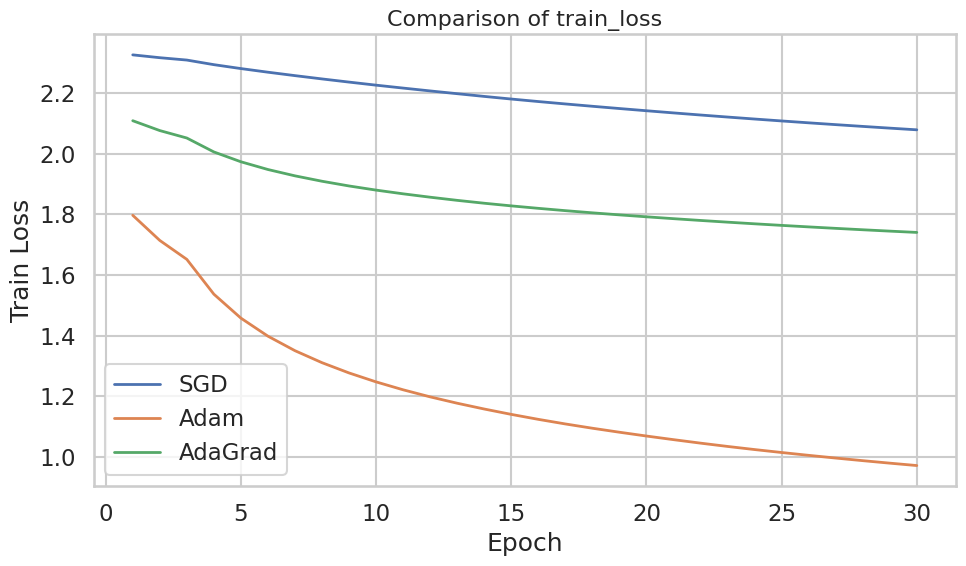

✅ Saved plot: eda_compare/compare_train_loss.png


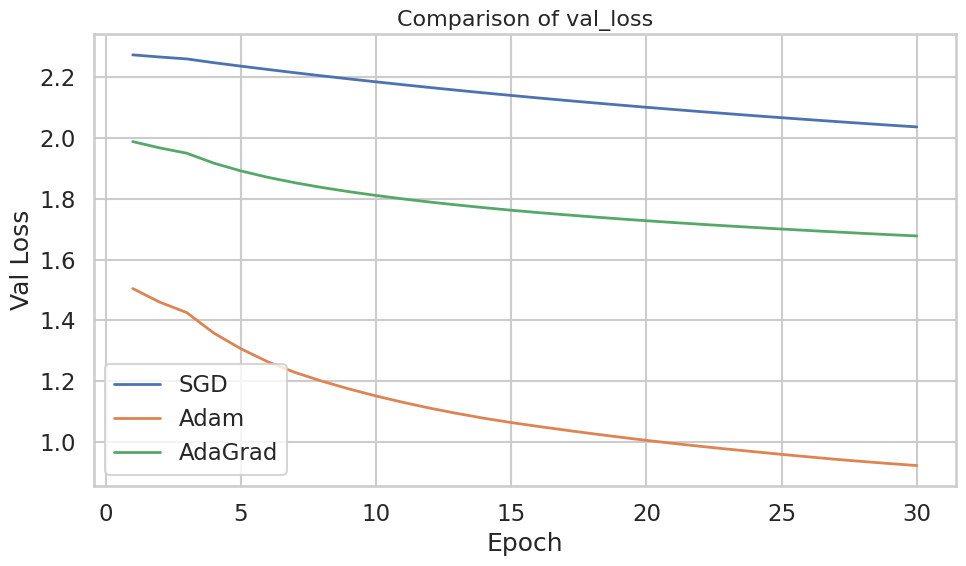

✅ Saved plot: eda_compare/compare_val_loss.png


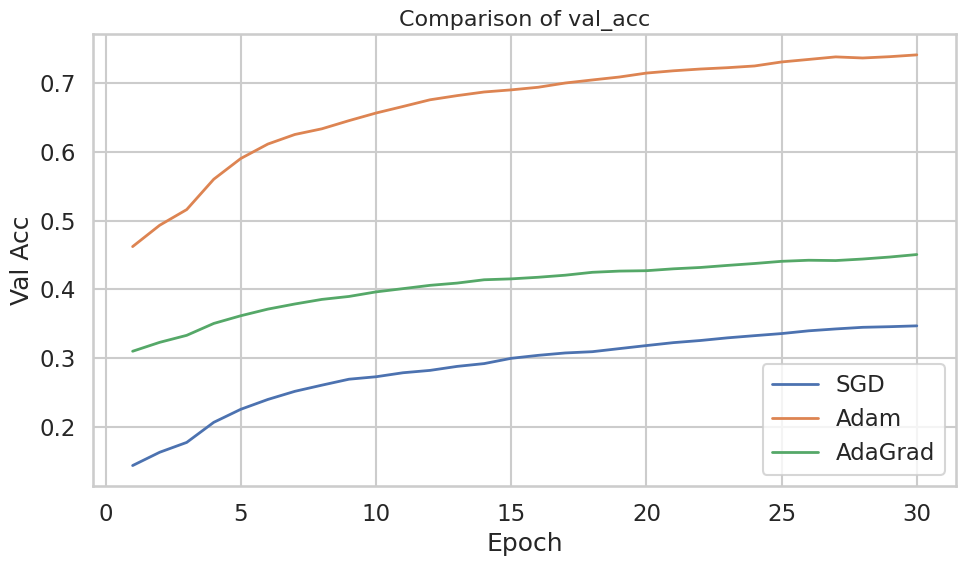

✅ Saved plot: eda_compare/compare_val_acc.png


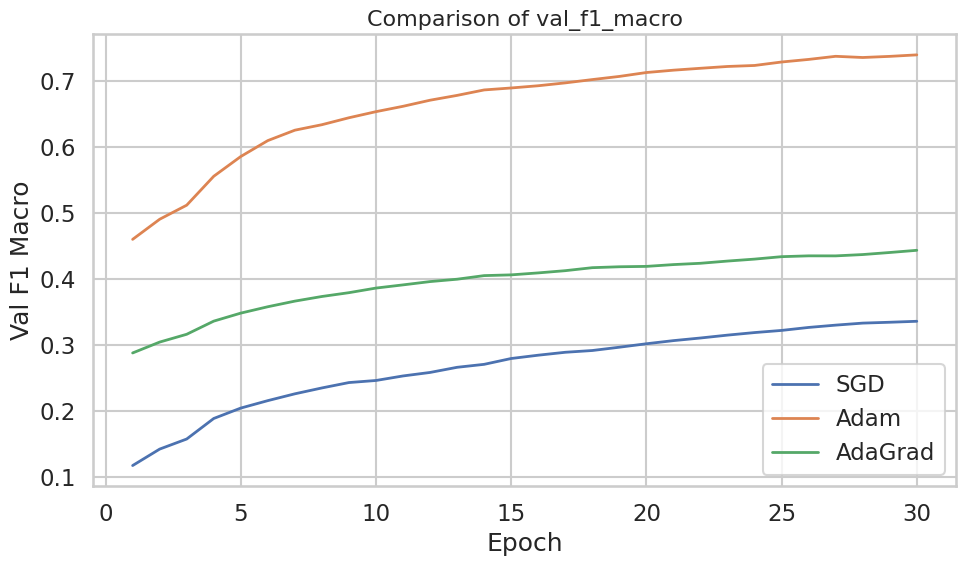

✅ Saved plot: eda_compare/compare_val_f1_macro.png


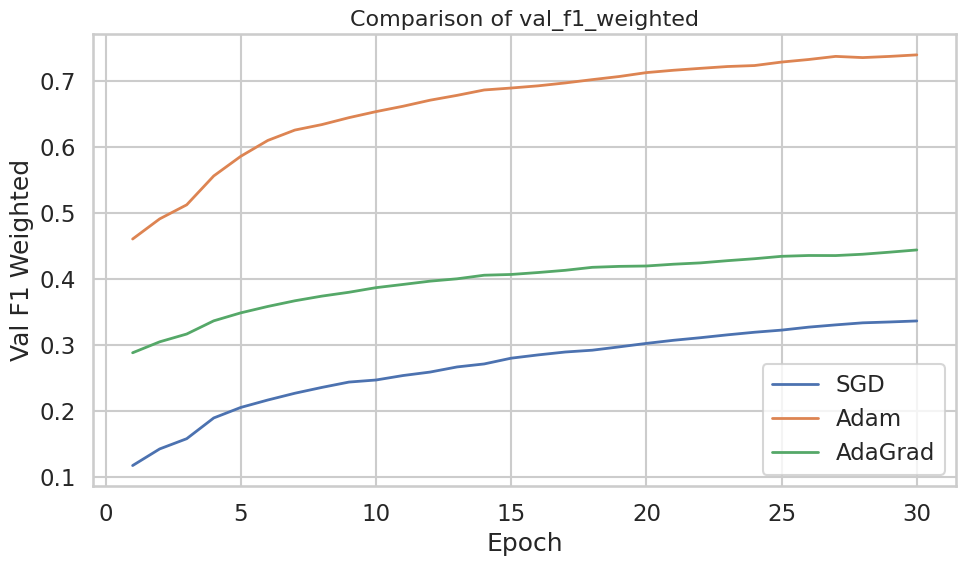

✅ Saved plot: eda_compare/compare_val_f1_weighted.png


In [40]:
for metric in metrics:
    plot_compare_metric(dfs, metric, save_dir="eda_compare", smooth_window=3)

# ***EDA TEST***

## ***Functions***

## ***Load Logs***

In [41]:
#-- Testing Logs Path
save_dir="/content/drive/MyDrive/QUÝNHEA/Project/models"
test_adaGrad_log_path = os.path.join(save_dir, "test_adaGrad_log.json")
test_adam_log_path = os.path.join(save_dir, "test_adam_log.json")
test_sgd_log_path = os.path.join(save_dir, "test_sgd_log.json")

In [43]:
#-- Testing Logs
test_adaGrad_log = load_json(test_adaGrad_log_path)
test_adam_log = load_json(test_adam_log_path)
test_sgd_log = load_json(test_sgd_log_path)

## ***EDA Functions***

In [52]:
def test_compare_plot(test_results_df):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.flatten()

    metrics = test_results_df.columns
    for i, metric in enumerate(metrics):
        sns.barplot(x=test_results_df.index, y=test_results_df[metric], ax=axes[i], palette="Set2")
        axes[i].set_title(metric.replace("_", " ").title(), fontsize=14)
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel("Optimizer")
        # Hiển thị giá trị trên cột
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt="%.3f", fontsize=10, padding=3)

    plt.tight_layout()
    plt.show()


## ***EDA***

In [50]:
test_results_log = {
    "SGD": test_sgd_log,
    "Adam": test_adam_log,
    "AdaGrad": test_adaGrad_log,
}

test_results_log_df = pd.DataFrame(test_results_log).T

/tmp/ipython-input-3824738837.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_results_df.index, y=test_results_df[metric], ax=axes[i], palette="Set2")
/tmp/ipython-input-3824738837.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_results_df.index, y=test_results_df[metric], ax=axes[i], palette="Set2")
/tmp/ipython-input-3824738837.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_results_df.index, y=test_results_df[metric], ax=axes[i], palette="Set2")
/tmp/ipython-input-3824738837.py:7: FutureWarning: 

Passing 

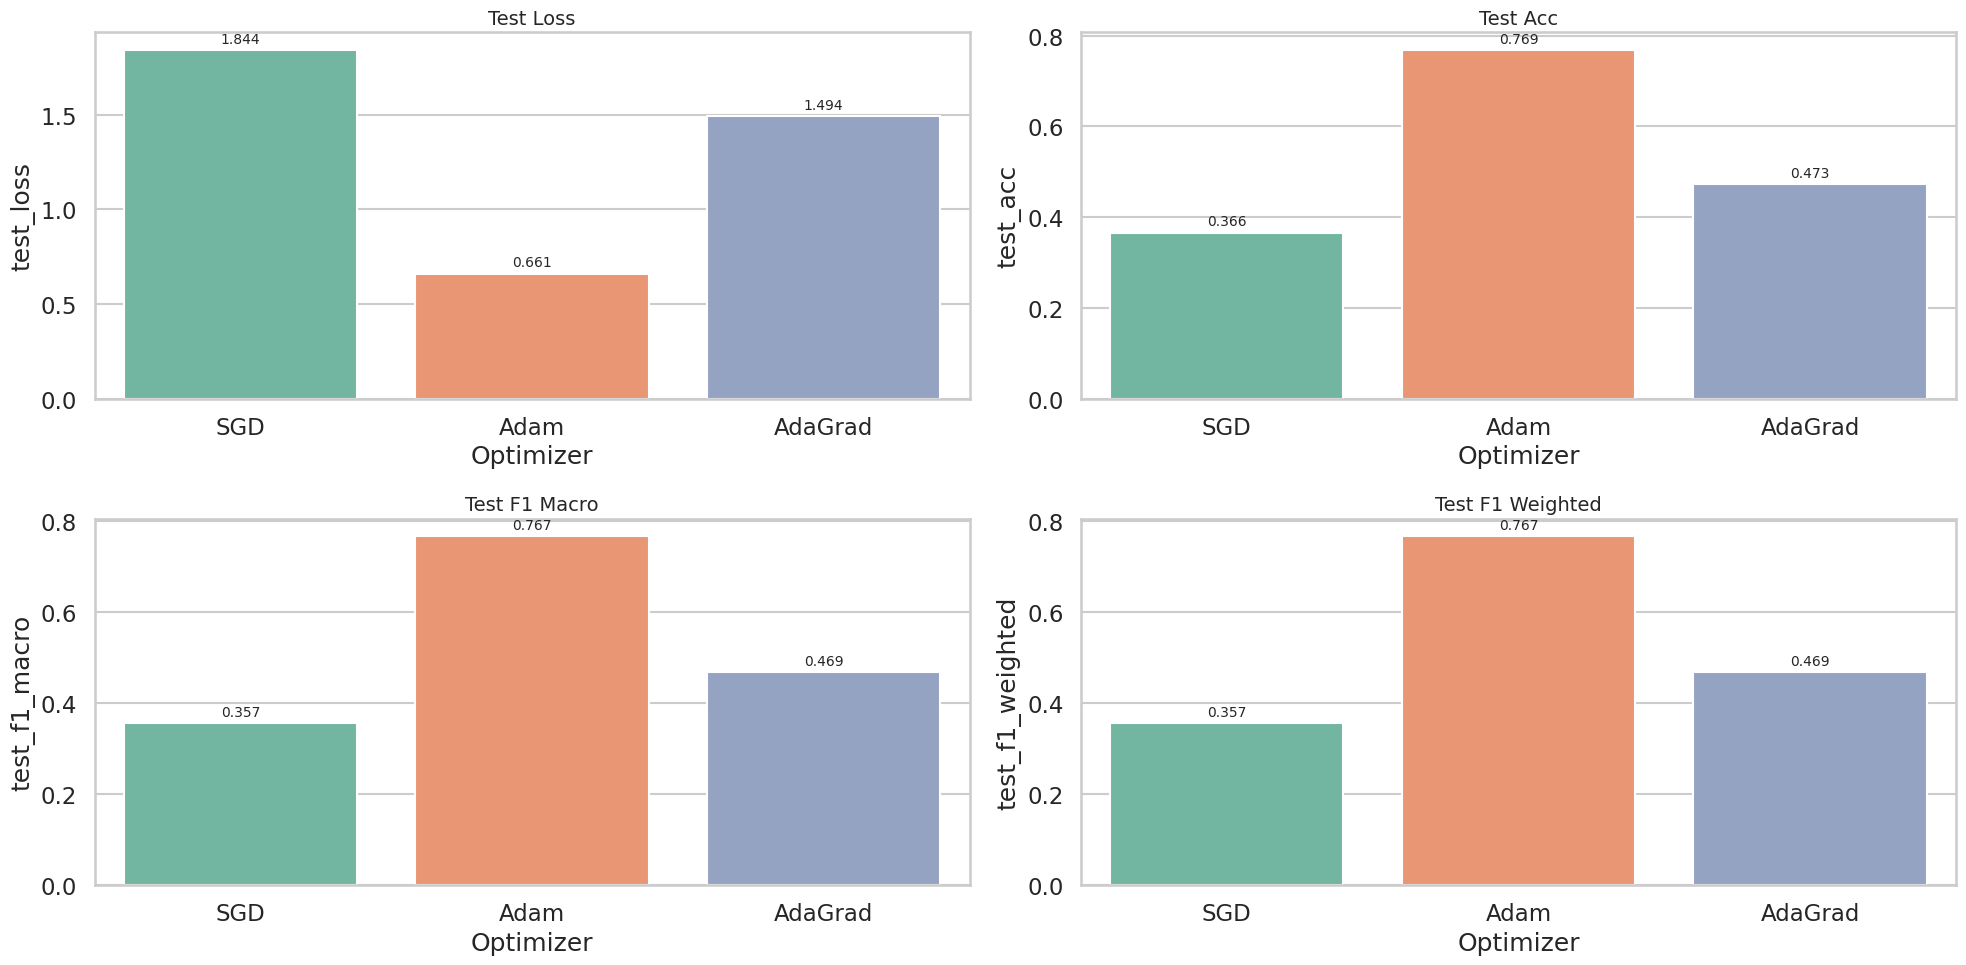

In [53]:
test_compare_plot(test_results_log_df)